## **1. Data Preparation**

In [2]:
# Step 1: Load Dataset
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

file_path = "C:/Users/User/UKM - Nur Azlin Binti Rusnan/Sem 3/Capstone Project/Dataset/2. Predictive Modeling Dataset/PM 18-12/PM-5.xlsx"
xls = pd.ExcelFile(file_path)

# Load the data from the first sheet
df = pd.read_excel(xls, sheet_name='Sheet1')

In [3]:
# Step 2: Preprocess the Sentiment Data for BERT
from sklearn.model_selection import train_test_split

# Map sentiment labels to numerical values
sentiment_mapping = {
    'Very Dissatisfied': 0,
    'Dissatisfied': 1,
    'Neutral': 2,
    'Satisfied': 3,
    'Very Satisfied': 4
}
df['Sentiment_Label'] = df['String value'].map(sentiment_mapping)

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["USS Comment"], df["Sentiment_Label"], test_size=0.2, stratify=df["Sentiment_Label"]
)

# Check distribution
print(train_texts.head(), train_labels.head())

df.head()

17857                                                   ok
13988                       dealt with quickly efficiently
9545          did great job solving my problem thanks tony
21633                                             good job
5890     great service provided by local team spite som...
Name: USS Comment, dtype: object 17857    4
13988    4
9545     4
21633    4
5890     4
Name: Sentiment_Label, dtype: int64


,Number,City,Country,Region,Average Response (calculated),USS Comment,String value,Year,Month-Year,Language,Predicted Sentiment,Confidence,Sentiment_Label
0,INC19299231,Midrand,South Africa,EAME,1,speedy and excellent followup and communicatio...,Very Satisfied,2024,November,english,LABEL_2,0.928918,4
1,INC19296281,Guyancourt,France,EAME,1,problem fixed quickly. thank you,Very Satisfied,2024,November,english,LABEL_2,0.938008,4
2,INC19300529,Didsbury,United Kingdom,EAME,1,malcolm did a great job in problem solving and...,Very Satisfied,2024,November,english,LABEL_2,0.930640,4
3,INC19300258,Bracknell,United Kingdom,EAME,1,thanks for the swift and awesome support and f...,Very Satisfied,2024,November,english,LABEL_2,0.935296,4
4,INC19301011,Didsbury,United Kingdom,EAME,1,great support from malcolm as usual,Very Satisfied,2024,November,english,LABEL_2,0.929943,4


### **a. Feature Engineering**

Use technique like BERT to convert comments into numerical representations.

In [4]:
# Step 3: Fine-Tune to my dataset, so BERT can learn the "lenggok" of user's comment.

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = BertForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", num_labels=len(sentiment_mapping))

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

# Encode the data
def encode_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    encodings['labels'] = torch.tensor(list(labels))
    return encodings

train_encodings = encode_data(train_texts, train_labels, tokenizer)
val_encodings = encode_data(val_texts, val_labels, tokenizer)

train_dataset = CustomDataset(train_encodings)
val_dataset = CustomDataset(val_encodings)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained("bert_sentiment_model_v2")
tokenizer.save_pretrained("bert_sentiment_model_v2")


Epoch,Training Loss,Validation Loss
1,0.556400,0.527770
2,0.479200,0.522230


('bert_sentiment_model_v2\\tokenizer_config.json',
 'bert_sentiment_model_v2\\special_tokens_map.json',
 'bert_sentiment_model_v2\\vocab.txt',
 'bert_sentiment_model_v2\\added_tokens.json')

In [4]:
# Step 4: Generate Predictions Using the Fine-Tuned BERT Model

from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the fine-tuned BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert_sentiment_model_v2")
model = BertForSequenceClassification.from_pretrained("bert_sentiment_model_v2")

# Function to predict sentiment
def predict_sentiment(texts, model, tokenizer):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            pred_class = torch.argmax(probs).item()
            predictions.append(pred_class)
    return predictions

# Predict sentiments for `USS Comment`
predicted_sentiments = predict_sentiment(df['USS Comment'].fillna(''), model, tokenizer)

# Map BERT output (0 to 4) to CSAT scale (5 to 1)
bert_to_csat_mapping = {0: 5, 1: 4, 2: 3, 3: 2, 4: 1}
df['Predicted_CSAT_Sentiment'] = [bert_to_csat_mapping[pred] for pred in predicted_sentiments]

# Add original predictions for reference (optional)
#df['Predicted_Sentiment'] = predicted_sentiments  # Original BERT outputs

# Display updated DataFrame
df.head()

,Number,City,Country,Region,Average Response (calculated),USS Comment,String value,Year,Month-Year,Language,Predicted Sentiment,Confidence,Sentiment_Label,Predicted_CSAT_Sentiment,Predicted_Sentiment
0,INC19299231,Midrand,South Africa,EAME,1,speedy and excellent followup and communicatio...,Very Satisfied,2024,November,english,LABEL_2,0.928918,4,1,4
1,INC19296281,Guyancourt,France,EAME,1,problem fixed quickly. thank you,Very Satisfied,2024,November,english,LABEL_2,0.938008,4,1,4
2,INC19300529,Didsbury,United Kingdom,EAME,1,malcolm did a great job in problem solving and...,Very Satisfied,2024,November,english,LABEL_2,0.930640,4,1,4
3,INC19300258,Bracknell,United Kingdom,EAME,1,thanks for the swift and awesome support and f...,Very Satisfied,2024,November,english,LABEL_2,0.935296,4,1,4
4,INC19301011,Didsbury,United Kingdom,EAME,1,great support from malcolm as usual,Very Satisfied,2024,November,english,LABEL_2,0.929943,4,1,4


In [ ]:
df = pd.read_csv("dataset_with_predictions.csv")

In [18]:
# Load the save file to save time

file_path = "C:/Users/User/UKM - Nur Azlin Binti Rusnan/Sem 3/Capstone Project/dataset_with_predictions.csv"  
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

        Number        City         Country Region  \
0  INC19299231     Midrand    South Africa   EAME   
1  INC19296281  Guyancourt          France   EAME   
2  INC19300529    Didsbury  United Kingdom   EAME   
3  INC19300258   Bracknell  United Kingdom   EAME   
4  INC19301011    Didsbury  United Kingdom   EAME   

   Average Response (calculated)  \
0                              1   
1                              1   
2                              1   
3                              1   
4                              1   

                                         USS Comment    String value  Year  \
0  speedy and excellent followup and communicatio...  Very Satisfied  2024   
1                   problem fixed quickly. thank you  Very Satisfied  2024   
2  malcolm did a great job in problem solving and...  Very Satisfied  2024   
3  thanks for the swift and awesome support and f...  Very Satisfied  2024   
4                great support from malcolm as usual  Very Satisfied  2024

In [5]:
# Step 5: Feature Engineering for Predictive Modeling

# Frequency encoding for Country
country_freq = df['Country'].value_counts(normalize=True).to_dict()
df['Country_Freq'] = df['Country'].map(country_freq)

# One-hot encoding for Region
region_encoded = pd.get_dummies(df['Region'], prefix='Region').astype(int)
df = pd.concat([df, region_encoded], axis=1)

# Drop existing Region-related columns if previously added
df = df.loc[:, ~df.columns.str.startswith('Region_')]

# Concatenate the one-hot encoded Region data
df = pd.concat([df, region_encoded], axis=1)

# Verify no duplicate columns exist
df = df.loc[:, ~df.columns.duplicated()]

# Prepare feature set and target
X = df[['Country_Freq'] + list(region_encoded.columns) + ['Predicted_CSAT_Sentiment']]
y = df['Average Response (calculated)']

X


,Country_Freq,Region_APAC,Region_EAME,Region_LATAM,Region_NORTH AMERICA,Predicted_CSAT_Sentiment
0,0.011430,0,1,0,0,1
1,0.039758,0,1,0,0,1
2,0.165397,0,1,0,0,1
3,0.165397,0,1,0,0,1
4,0.165397,0,1,0,0,1
...,...,...,...,...,...,...
22305,0.193456,1,0,0,0,5
22306,0.197848,0,0,0,1,1
22307,0.193456,1,0,0,0,1
22308,0.197848,0,0,0,1,5


In [6]:
# Step 6: Predictive Modeling

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import shap

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models to evaluate
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

# Evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Results:")
    print(f"MAE: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}")


Training Random Forest...
Random Forest Results:
MAE: 0.2710
Mean Squared Error: 0.2371
RMSE: 0.4869
R-squared: 0.7758

Training Gradient Boosting...
Gradient Boosting Results:
MAE: 0.2712
Mean Squared Error: 0.2371
RMSE: 0.4869
R-squared: 0.7758

Training Support Vector Regressor...
Support Vector Regressor Results:
MAE: 0.2556
Mean Squared Error: 0.2485
RMSE: 0.4985
R-squared: 0.7650


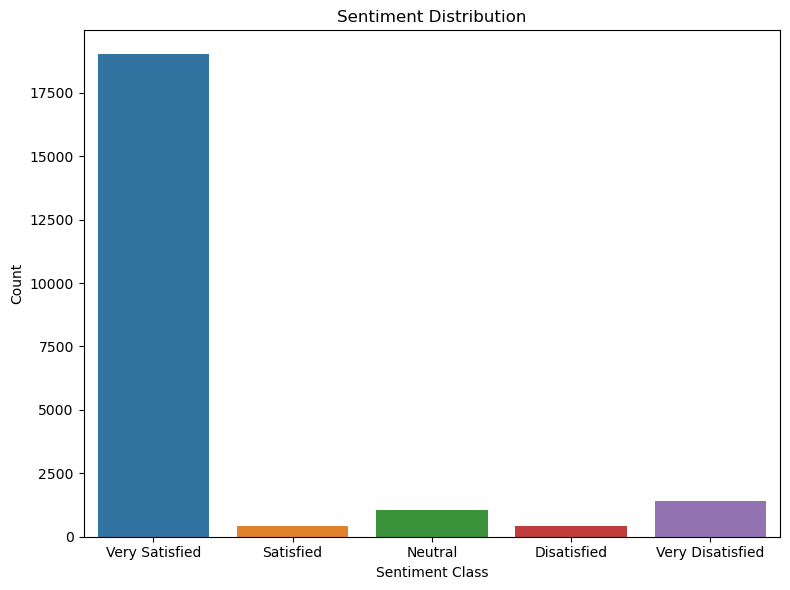

In [8]:
# Sentiment Distribution

import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment class
sentiment_counts = df['Predicted_CSAT_Sentiment'].value_counts().sort_index()

# Bar chart for sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.xticks(ticks=range(5), labels=["Very Satisfied", "Satisfied", "Neutral", "Disatisfied", "Very Disatisfied"])
plt.tight_layout()
plt.show()


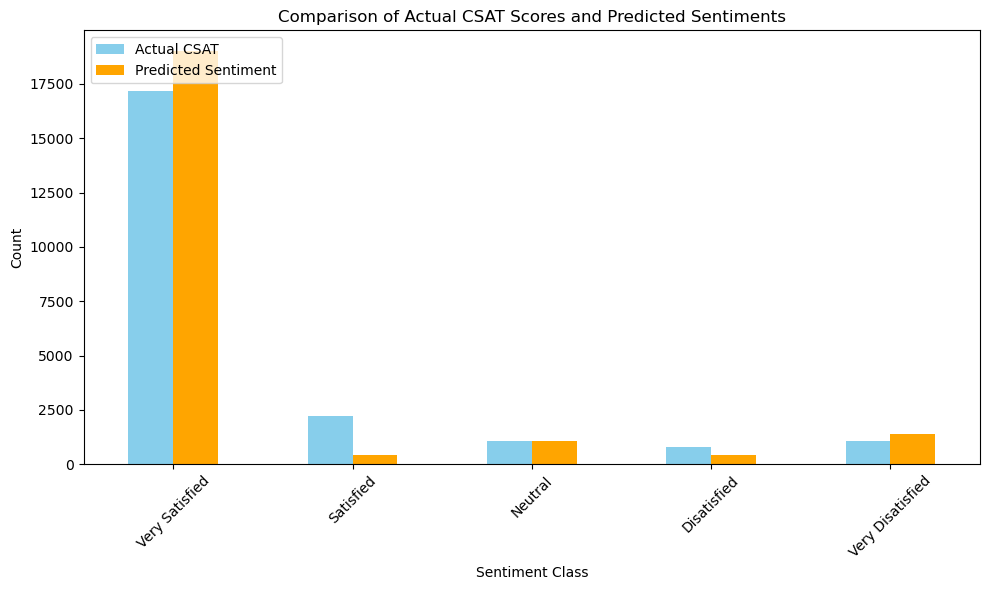

In [9]:
# relationship between the actual CSAT scores (Average Response (calculated)) and the predicted sentiments from BERT
#tgk ni balik

# Step 1: Count occurrences of Actual CSAT and Predicted Sentiments
actual_counts = df['Average Response (calculated)'].value_counts().sort_index()
predicted_counts = df['Predicted_CSAT_Sentiment'].value_counts().sort_index()

# Step 2: Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual CSAT': actual_counts,
    'Predicted Sentiment': predicted_counts
})

# Step 3: Plot side-by-side bar chart
comparison_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title("Comparison of Actual CSAT Scores and Predicted Sentiments")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.xticks(ticks=range(5), labels=["Very Satisfied", "Satisfied", "Neutral", "Disatisfied", "Very Disatisfied"], rotation=45)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


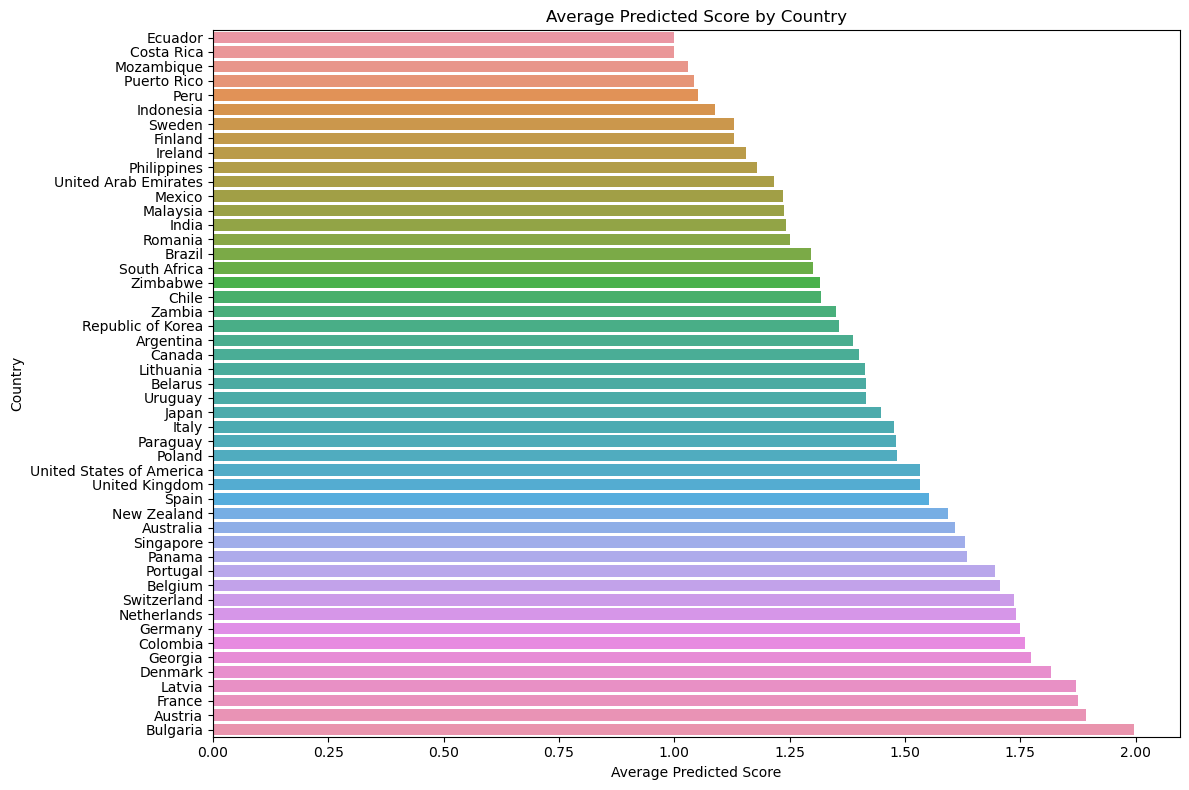

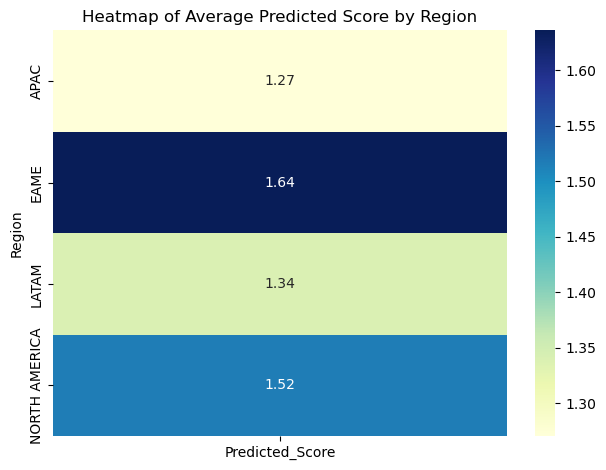

,Number,City,Country,Region,Average Response (calculated),USS Comment,String value,Year,Month-Year,Language,...,Confidence,Sentiment_Label,Predicted_CSAT_Sentiment,Predicted_Sentiment,Country_Freq,Region_APAC,Region_EAME,Region_LATAM,Region_NORTH AMERICA,Predicted_Score
0,INC19299231,Midrand,South Africa,EAME,1,speedy and excellent followup and communicatio...,Very Satisfied,2024,November,english,...,0.928918,4,1,4,0.011430,0,1,0,0,1.094260
1,INC19296281,Guyancourt,France,EAME,1,problem fixed quickly. thank you,Very Satisfied,2024,November,english,...,0.938008,4,1,4,0.039758,0,1,0,0,1.179830
2,INC19300529,Didsbury,United Kingdom,EAME,1,malcolm did a great job in problem solving and...,Very Satisfied,2024,November,english,...,0.930640,4,1,4,0.165397,0,1,0,0,1.099702
3,INC19300258,Bracknell,United Kingdom,EAME,1,thanks for the swift and awesome support and f...,Very Satisfied,2024,November,english,...,0.935296,4,1,4,0.165397,0,1,0,0,1.099702
4,INC19301011,Didsbury,United Kingdom,EAME,1,great support from malcolm as usual,Very Satisfied,2024,November,english,...,0.929943,4,1,4,0.165397,0,1,0,0,1.099702


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Calculate average predicted response by Country
df['Predicted_Score'] = models['Random Forest'].predict(X)  
country_avg_pred = df.groupby('Country')['Predicted_Score'].mean().sort_values()

# Bar chart for Country
plt.figure(figsize=(12, 8))
sns.barplot(x=country_avg_pred.values, y=country_avg_pred.index)
plt.title("Average Predicted Score by Country")
plt.xlabel("Average Predicted Score")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Heatmap for Region
region_avg_pred = df.pivot_table(index='Region', values='Predicted_Score', aggfunc='mean')
sns.heatmap(region_avg_pred, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap of Average Predicted Score by Region")
plt.tight_layout()
plt.show()

df.head()


**Insights**:

1) What the Random Forest model predicts for the future.
2) These are the predicted scores (Predicted_Score) generated by the Random Forest model for the Average Response (calculated) target (1,2,3,4,5)

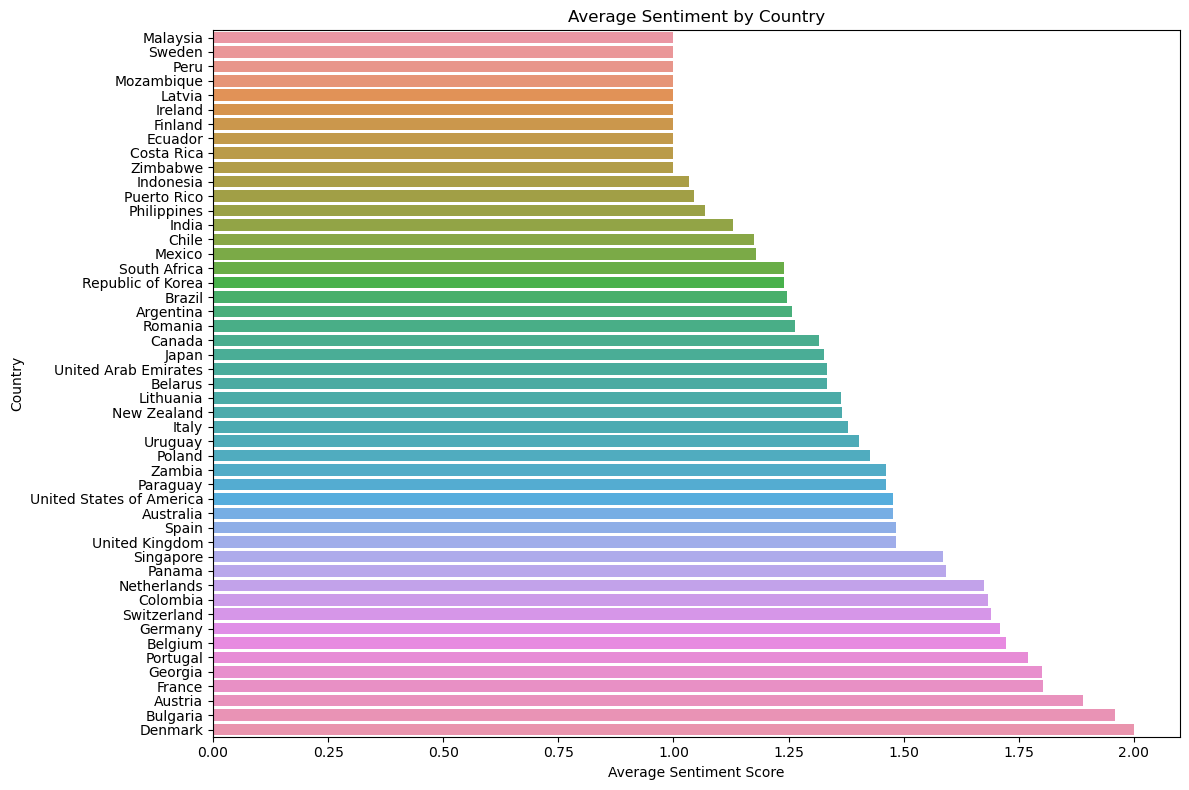

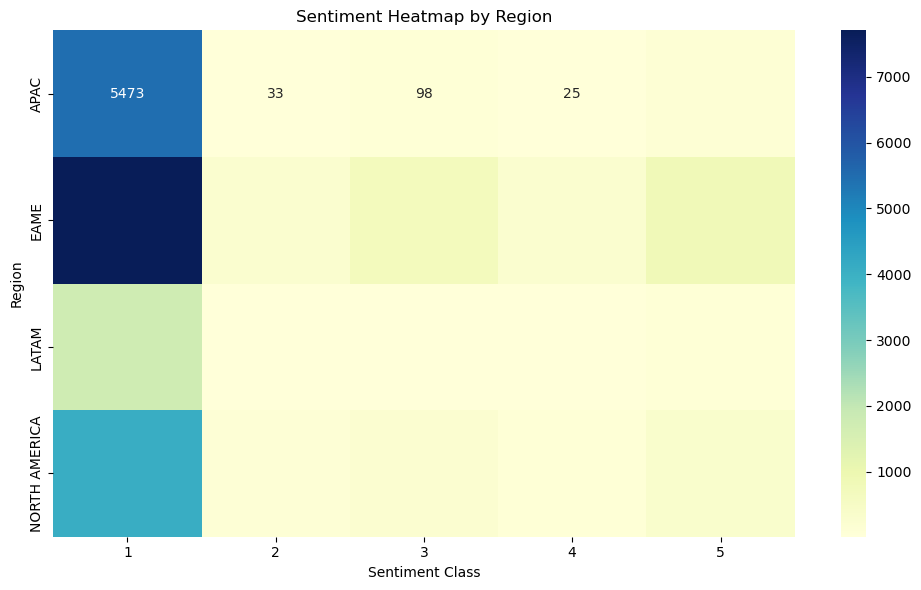

In [12]:
# 2. Sentiment by Feature 

# Average sentiment by country
sentiment_by_country = df.groupby('Country')['Predicted_CSAT_Sentiment'].mean().sort_values()

# Bar chart for average sentiment by country
plt.figure(figsize=(12, 8))
sns.barplot(x=sentiment_by_country.values, y=sentiment_by_country.index)
plt.title("Average Sentiment by Country")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# Pivot table for sentiment by region
region_sentiment = df.pivot_table(index='Region', columns='Predicted_CSAT_Sentiment', aggfunc='size', fill_value=0)

# Heatmap for sentiment by region
plt.figure(figsize=(10, 6))
sns.heatmap(region_sentiment, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Sentiment Heatmap by Region")
plt.xlabel("Sentiment Class")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


**Insights:**

1) These are the sentiment scores (Predicted_Sentiment) derived from customer comments using a sentiment analysis model like BERT.

2) The sentiment scores are on a pre-defined numerical scale:

    'Very Dissatisfied': 0,
    'Dissatisfied': 1,
    'Neutral': 2,
    'Satisfied': 3,
    'Very Satisfied': 4

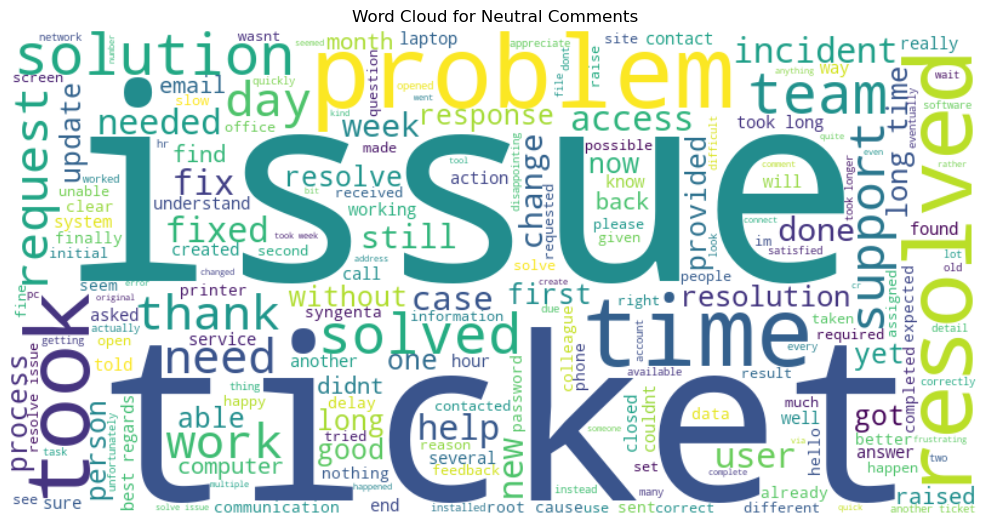

In [15]:
# Word Clouds for Sentiments

from wordcloud import WordCloud

# Generate a word cloud for a specific sentiment class
sentiment_class = 3  # Neutral
comments = " ".join(df[df['Predicted_CSAT_Sentiment'] == sentiment_class]['USS Comment'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(comments)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Neutral Comments")
plt.tight_layout()
plt.show()


In [44]:
# Step 7: Save and Load Random Forest Model


from joblib import dump, load

# Use Random Forest as the final model
rf_model = models['Random Forest']

# Save the trained model
dump(rf_model, "random_forest_model.pkl")
print("Random Forest model saved as 'random_forest_model.pkl'.")

from transformers import BertTokenizer, BertForSequenceClassification

# Load the fine-tuned BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert_sentiment_model_v2")
sentiment_model = BertForSequenceClassification.from_pretrained("bert_sentiment_model_v2")


# Function to make predictions for new inputs
def predict_csat_summary(location_type, location_value, df, comment=None, sentiment_model=None, tokenizer=None, rf_model=None, region_encoded=None):
    """
    Predict the average CSAT score, percentages of positive, neutral, and negative feedback,
    and number of responses for a specific country or region. 
    Predict the CSAT score from the comment and include it in the summary.
    """
    try:
        summary = {}
        
        # Step 1: Predict CSAT for the comment, if provided
        if comment and sentiment_model and tokenizer and rf_model and region_encoded is not None:
            inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True, max_length=128)
            outputs = sentiment_model(**inputs)
            sentiment_score = torch.argmax(outputs.logits).item()  # Get the predicted sentiment class (0–4)

            # Map sentiment score to CSAT scale
            sentiment_to_csat = {0: 5, 1: 4, 2: 3, 3: 2, 4: 1}
            predicted_csat_sentiment = sentiment_to_csat[sentiment_score]

            # Get frequency encoding for country
            country_freq = df['Country'].value_counts(normalize=True).to_dict()
            country_contribution = country_freq.get(location_value, 0)  # Default to 0 if country is not in the dataset

            # Get one-hot encoding for region
            region_columns = list(region_encoded.columns)
            region_values = [1 if f"Region_{location_value}" == col else 0 for col in region_columns]

            # Combine features
            input_features = [country_contribution] + region_values + [predicted_csat_sentiment]

            # Predict CSAT score using the Random Forest model
            predicted_csat_score = rf_model.predict([input_features])[0]
            
            # Add comment CSAT summary
            summary['Comment CSAT Summary'] = {
                "Comment": comment,
                "Average Predicted CSAT for Comment": round(predicted_csat_score, 2)
            }
        
        # Step 2: Filter data based on location type (Region or Country)
        if location_type.lower() == "region":
            filtered_data = df[df['Region'] == location_value]
        elif location_type.lower() == "country":
            filtered_data = df[df['Country'] == location_value]
        else:
            return {"Error": "Invalid location type. Use 'Region' or 'Country'."}
        
        if filtered_data.empty:
            return {"Error": f"No data available for {location_type}: {location_value}"}
        
        # Step 3: Calculate metrics
        avg_csat = round(filtered_data['Predicted_Score'].mean(), 2)
        total_responses = len(filtered_data)
        
        # Define feedback categories
        positive_responses = filtered_data[filtered_data['Predicted_CSAT_Sentiment'] <= 2].shape[0]  # CSAT 1, 2 are positive
        neutral_responses = filtered_data[filtered_data['Predicted_CSAT_Sentiment'] == 3].shape[0]   # CSAT 3 is neutral
        negative_responses = filtered_data[filtered_data['Predicted_CSAT_Sentiment'] >= 4].shape[0]  # CSAT 4, 5 are negative
        
        # Calculate percentages
        positive_percentage = round((positive_responses / total_responses) * 100, 2)
        neutral_percentage = round((neutral_responses / total_responses) * 100, 2)
        negative_percentage = round((negative_responses / total_responses) * 100, 2)
        
        # Add location-specific summary
        summary[f"{location_type.capitalize()} CSAT Summary"] = {
            location_type.capitalize(): location_value,
            "Average Predicted CSAT": avg_csat,
            "Positive Feedback (%)": positive_percentage,
            "Neutral Feedback (%)": neutral_percentage,
            "Negative Feedback (%)": negative_percentage,
            "Number of Responses": total_responses
        }
        
        return summary
    except Exception as e:
        return {"Error": str(e)}

# Example usage
example_comment = "The service was amazing and resolved my issue quickly!"
example_region = "APAC"
example_country = "Bulgaria"

# Prediction
summary = {}
summary.update(predict_csat_summary("region", example_region, df, comment=example_comment, sentiment_model=sentiment_model, tokenizer=tokenizer, rf_model=models['Random Forest'], region_encoded=region_encoded))
summary.update(predict_csat_summary("country", example_country, df))

# Display results
for section, metrics in summary.items():
    print(f"\n{section}:")
    print(f"{'Metric':<60} {'Value':<30}")
    print("-" * 90)
    for key, value in metrics.items():
        print(f"{key:<60} {value:<30}")


Random Forest model saved as 'random_forest_model.pkl'.

Comment CSAT Summary:
Metric                                                       Value                         
------------------------------------------------------------------------------------------
Comment                                                      The service was amazing and resolved my issue quickly!
Average Predicted CSAT for Comment                           1.23                          

Region CSAT Summary:
Metric                                                       Value                         
------------------------------------------------------------------------------------------
Region                                                       APAC                          
Average Predicted CSAT                                       1.27                          
Positive Feedback (%)                                        95.19                         
Neutral Feedback (%)                             